# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
# azdias
print(azdias.shape)
azdias.head()


(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
# feature_
print(feat_info.shape)
feat_info.head()

(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
print('Number of missing values before conversion is {}'.format(azdias.isnull().sum().sum()))

Number of missing values before conversion is 4896838


In [6]:
for ii in range(len(feat_info)):
    missing_unknown = feat_info.iloc[ii]['missing_or_unknown']
    missing_unknown = missing_unknown.lstrip('[')
    missing_unknown = missing_unknown.rstrip(']')
    missing_unknown = missing_unknown.split(',')
    for value in missing_unknown:
        if value != 'X' and value != 'XX' and value !='': 
            azdias.iloc[:,ii].replace({int(value): np.nan}, inplace = True)
        elif value == 'X' or value == 'XX':
            azdias.iloc[:,ii].replace({value: np.nan}, inplace = True)

In [7]:
print('Number of missing values after conversion is {}'.format(azdias.isnull().sum().sum()))

Number of missing values after conversion is 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [8]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
perc_missing = azdias.isnull().sum()/len(azdias)*100
perc_missing.sort_values(ascending=False).head(10)

TITEL_KZ          99.757636
AGER_TYP          76.955435
KK_KUNDENTYP      65.596749
KBA05_BAUMAX      53.468668
GEBURTSJAHR       44.020282
ALTER_HH          34.813699
REGIOTYP          17.735668
KKK               17.735668
W_KEIT_KIND_HH    16.605084
KBA05_ANTG4       14.959701
dtype: float64

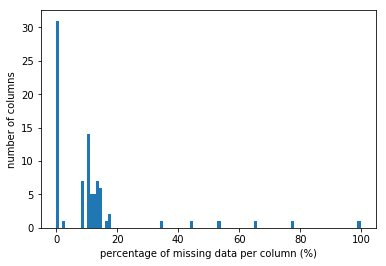

In [9]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(perc_missing, bins = 100)
plt.xlabel('percentage of missing data per column (%)')
plt.ylabel('number of columns')
plt.show()

In [10]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
drop_list = list()
for ii in range(len(perc_missing)):
    if perc_missing[ii] > 20:
        print(perc_missing[ii])
        drop_list.append(ii)
print(drop_list)
azdias.drop(azdias.columns[drop_list], axis = 1, inplace = True)
feat_info_new = feat_info.drop(drop_list) #we also need a new feat_info later
# Note: I will also drop these 6 features in the customer dataset

76.9554352961
44.0202822869
99.7576358726
34.8136994079
65.5967487301
53.4686682652
[0, 11, 40, 43, 47, 64]


In [11]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

Answer: From the histogram, it's clear that most of the columns have less than 20% missing data. I also sorted the perc_missing values from highest to lowest and it's clear that there're only 6 columns with more than 20% missing data. So I drop those 6 columns and now the "azdias" dataframe has only 79 columns, as shown in the last cell above.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [12]:
# How much data is missing in each row of the dataset?
missing_per_row = azdias.isnull().sum(axis=1)
missing_per_row.head()

0    43
1     0
2     0
3     7
4     0
dtype: int64

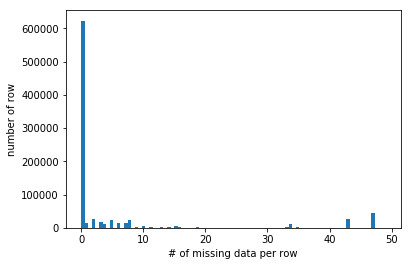

In [13]:
plt.hist(missing_per_row, bins = 85)
plt.xlabel('# of missing data per row')
plt.ylabel('number of row')
plt.show()

In [14]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_more_missing = azdias[azdias.isnull().sum(axis=1) > 25]
azdias_less_missing = azdias[azdias.isnull().sum(axis=1) <= 25]

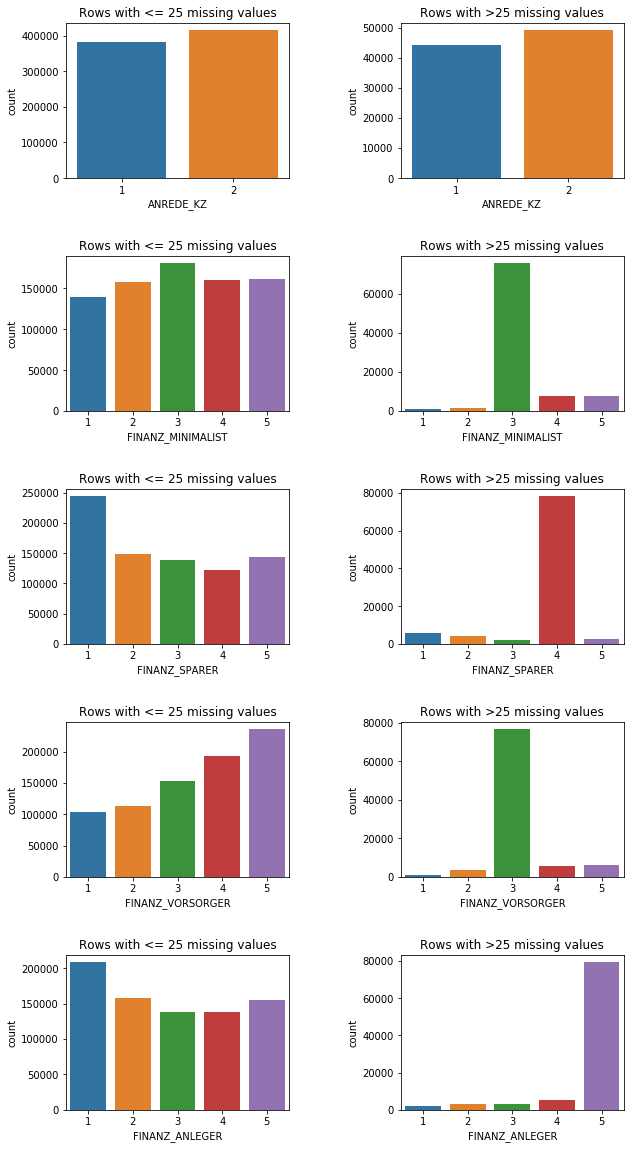

In [15]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
zero_missing_columns = perc_missing[perc_missing==0].index.tolist()
compare_5_columns = zero_missing_columns[:5]
figure, axs = plt.subplots(nrows=len(compare_5_columns), ncols=2, figsize = (10,20))
figure.subplots_adjust(hspace = 0.5, wspace = 0.5)
for ii in range(len(compare_5_columns)):
    sns.countplot(azdias_less_missing[compare_5_columns[ii]], ax=axs[ii][0])
    axs[ii][0].set_title('Rows with <= 25 missing values')
    sns.countplot(azdias_more_missing[compare_5_columns[ii]], ax=axs[ii][1])
    axs[ii][1].set_title('Rows with >25 missing values')

#### Discussion 1.1.3: Assess Missing Data in Each Row

Answer: From the countplot above, it's clear that except for "ANREDE_KZ" feature, all other selected features show very different distribution between rows with <= 25 missing values and rows with > 25 missing values (I chose 25 as threshold because there are two clear groups in the histogram). Therefore, the rows with more missing points are "special" and we should revisit them later.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [16]:
# How many features are there of each data type?
# Note: here I use "feat_info" (based on the question), which has 85 features, and keep in mind that previously we've dropped 6 features with many missing values so later I will use "new_feat_info" that was crated previously
print('# of numeric features: {}'.format((feat_info.loc[:,'type']=='numeric').sum()))
print('# of interval features: {}'.format((feat_info.loc[:,'type']=='interval').sum()))
print('# of ordinal features: {}'.format((feat_info.loc[:,'type']=='ordinal').sum()))
print('# of categorical features: {}'.format((feat_info.loc[:,'type']=='categorical').sum()))
print('# of mixed features: {}'.format((feat_info.loc[:,'type']=='mixed').sum()))

# of numeric features: 7
# of interval features: 1
# of ordinal features: 49
# of categorical features: 21
# of mixed features: 7


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [17]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# Note that I use "feat_info_new" which contains 79 features in the following analysis
categorical_features = feat_info_new[feat_info_new["type"]=="categorical"]["attribute"]
binary_features = list()
multi_level_features = list()
for feature in categorical_features:
    if len(azdias_less_missing[feature].unique()) == 2:
        binary_features.append(feature)
        print(feature,azdias_less_missing[feature].unique())
    else:
        multi_level_features.append(feature)

ANREDE_KZ [2 1]
GREEN_AVANTGARDE [0 1]
SOHO_KZ [ 1.  0.]
OST_WEST_KZ ['W' 'O']


In [18]:
# Re-encode categorical variable(s) to be kept in the analysis.
# from the output of the above cell, we can see that "OST_WEST_KZ" is a binary feature that takes on non-numeric values.
azdias_less_missing['OST_WEST_KZ'].replace({'W': 1, 'O': 0}, inplace = True)
# check
print(azdias_less_missing['OST_WEST_KZ'].head())

1    1
2    1
3    1
4    1
5    1
Name: OST_WEST_KZ, dtype: int64


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [19]:
# drop the multi-level categorical features
azdias_less_missing.drop(columns = multi_level_features, axis = 1, inplace = True)
azdias_less_missing.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


#### Discussion 1.2.1: Re-Encode Categorical Features

Answer: I found that "OST_WEST_KZ" is a binary categorical features with "W" and "O" values, so I replaced them with "1" and "0". To keep things straightforward, I dropped the multi-level categorical features.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [20]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_less_missing['decade'] = azdias_less_missing['PRAEGENDE_JUGENDJAHRE']
azdias_less_missing['movement'] = azdias_less_missing['PRAEGENDE_JUGENDJAHRE']
decade_dictionary = {1:4, 2:4, 3:5, 4:5, 5:6, 6:6, 7:6, 8:7, 9:7, 10:8, 11:8, 12:8, 13:8, 14:9, 15:9}
movement_dictionary = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
azdias_less_missing['decade'].replace(decade_dictionary, inplace = True)
azdias_less_missing['movement'].replace(movement_dictionary, inplace = True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

In [21]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_less_missing['wealth'] = pd.to_numeric(azdias_less_missing['CAMEO_INTL_2015'],errors='nan')
azdias_less_missing['life_stage'] = pd.to_numeric(azdias_less_missing['CAMEO_INTL_2015'],errors='nan')
wealth_dictionary = {11:1, 12:1, 13:1, 14:1, 15:1, 21:2, 22:2, 23:2, 24:2, 25:2, 31:3, 32:3, 33:3, 34:3, 35:3, 41:4, 42:4, 43:4, 44:4, 45:4, 51:5, 52:5, 53:5, 54:5, 55:5}
ls_dictionary = {11:1, 12:2, 13:3, 14:4, 15:5, 21:1, 22:2, 23:3, 24:4, 25:5, 31:1, 32:2, 33:3, 34:4, 35:5, 41:1, 42:2, 43:3, 44:4, 45:5, 51:1, 52:2, 53:3, 54:4, 55:5}
azdias_less_missing['wealth'].replace(wealth_dictionary, inplace = True)
azdias_less_missing['life_stage'].replace(ls_dictionary, inplace = True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

#### Discussion 1.2.2: Engineer Mixed-Type Features

Answer: I followed the instructions and created four new features -- decade, movement, wealth, and life_stage -- from the two mixed features "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015". I performed a replacement based on "data_dictionary.md".

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [22]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias_less_missing.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,9.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,9.0,1.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,7.0,0.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,7.0,0.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,5.0,0.0,5.0,4.0


In [23]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
mixed_features = feat_info_new[feat_info_new["type"]=="mixed"]["attribute"]
mixed_features

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [24]:
# drop the mixed features (including the two features I just de-coupled)
azdias_less_missing.drop(columns = mixed_features, axis = 1, inplace = True)
azdias_less_missing.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,decade,movement,wealth,life_stage
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,9.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,9.0,1.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,7.0,0.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,7.0,0.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,5.0,0.0,5.0,4.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [25]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for ii in range(len(feat_info)):
        missing_unknown = feat_info.iloc[ii]['missing_or_unknown']
        missing_unknown = missing_unknown.lstrip('[')
        missing_unknown = missing_unknown.rstrip(']')
        missing_unknown = missing_unknown.split(',')
        for value in missing_unknown:
            if value != 'X' and value != 'XX' and value !='': 
                df.iloc[:,ii].replace({int(value): np.nan}, inplace = True)
            elif value == 'X' or value == 'XX':
                df.iloc[:,ii].replace({value: np.nan}, inplace = True)
    
    # remove selected columns and rows, ...
    # Note: I think we should keep the same features between the data we work on and the customer's data, so I manually typed in the 6 features that we dropped because of many missing values
    columns_missing_20 = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
    df.drop(columns_missing_20, axis = 1, inplace = True)
    # Note: the drop_list was from previous output
    feat_info_new = feat_info.drop([0, 11, 40, 43, 47, 64]) #we also need a new feat_info later
    
    # will use rows with fewer than 25 missing data for analysis
    df_less_missing = df[df.isnull().sum(axis=1) <= 25]
    
    # select, re-encode, and engineer column values.
    # find out binary and multi-level categorical features
    categorical_features = feat_info_new[feat_info_new["type"]=="categorical"]["attribute"]
    binary_features = list()
    multi_level_features = list()
    for feature in categorical_features:
        if len(df_less_missing[feature].unique()) == 2:
            binary_features.append(feature)
        else:
            multi_level_features.append(feature)
    # mapping the binary "OST_WEST_KZ" feature
    df_less_missing['OST_WEST_KZ'].replace({'W': 1, 'O': 0}, inplace = True)
    # drop multi-level features
    df_less_missing.drop(columns = multi_level_features, axis = 1, inplace = True)
    
    # for mixed features, first decouple the 4 features from "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015"
    # "PRAEGENDE_JUGENDJAHRE"
    df_less_missing['decade'] = df_less_missing['PRAEGENDE_JUGENDJAHRE']
    df_less_missing['movement'] = df_less_missing['PRAEGENDE_JUGENDJAHRE']
    decade_dictionary = {1:4, 2:4, 3:5, 4:5, 5:6, 6:6, 7:6, 8:7, 9:7, 10:8, 11:8, 12:8, 13:8, 14:9, 15:9}
    movement_dictionary = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
    df_less_missing['decade'].replace(decade_dictionary, inplace = True)
    df_less_missing['movement'].replace(movement_dictionary, inplace = True)
    # "CAMEO_INTL_2015"
    df_less_missing['wealth'] = pd.to_numeric(df_less_missing['CAMEO_INTL_2015'],errors='nan')
    df_less_missing['life_stage'] = pd.to_numeric(df_less_missing['CAMEO_INTL_2015'],errors='nan')
    wealth_dictionary = {11:1, 12:1, 13:1, 14:1, 15:1, 21:2, 22:2, 23:2, 24:2, 25:2, 31:3, 32:3, 33:3, 34:3, 35:3, 41:4, 42:4, 43:4, 44:4, 45:4, 51:5, 52:5, 53:5, 54:5, 55:5}
    ls_dictionary = {11:1, 12:2, 13:3, 14:4, 15:5, 21:1, 22:2, 23:3, 24:4, 25:5, 31:1, 32:2, 33:3, 34:4, 35:5, 41:1, 42:2, 43:3, 44:4, 45:5, 51:1, 52:2, 53:3, 54:4, 55:5}
    df_less_missing['wealth'].replace(wealth_dictionary, inplace = True)
    df_less_missing['life_stage'].replace(ls_dictionary, inplace = True)
    # then drop mixed features
    mixed_features = feat_info_new[feat_info_new["type"]=="mixed"]["attribute"]
    df_less_missing.drop(columns = mixed_features, axis = 1, inplace = True)
    
    #  Return the cleaned dataframe.
    return df_less_missing
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [26]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# Note to myself: is mean the best strategy? other: median, most_frequent (If revisit this project in the future I should try median and most_frequent as strategy)
imp = Imputer(strategy='mean')
azdias_imp = pd.DataFrame(imp.fit_transform(azdias_less_missing), columns = list(azdias_less_missing))

In [27]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_imp_scaled = pd.DataFrame(scaler.fit_transform(azdias_imp), columns = list(azdias_less_missing))

### Discussion 2.1: Apply Feature Scaling

Answer:  
-- Following the instructions, I applied an Imputer to replace all the missing values.  
-- I also used StandardScaler to do the feature scaling.  
-- I looked over the documents and tried my best to make the codes short and handy.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [28]:
# Apply PCA to the data.
def do_pca(n_components, data):
    pca = PCA(n_components)
    data_pca = pca.fit_transform(data)
    return pca, data_pca

In [29]:
# I chose 40 components b/c there were 63 features so 40 > (63/2)
n_components = 40
pca, azdias_pca = do_pca(n_components, azdias_imp_scaled)

In [30]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    print(cumvals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

[ 0.17067732  0.30718739  0.40344416  0.45690204  0.49514376  0.52738712
  0.55533512  0.58058256  0.60248255  0.62381878  0.64487039  0.66397216
  0.68279786  0.70076836  0.71769432  0.7339127   0.74977773  0.76444038
  0.77780323  0.79099183  0.80326181  0.81525634  0.82696124  0.83799102
  0.84770045  0.85572137  0.86331874  0.87084717  0.87814851  0.88514234
  0.89179005  0.89838766  0.90478523  0.91096365  0.9170594   0.9226554
  0.92771411  0.93269056  0.93729271  0.94166155]


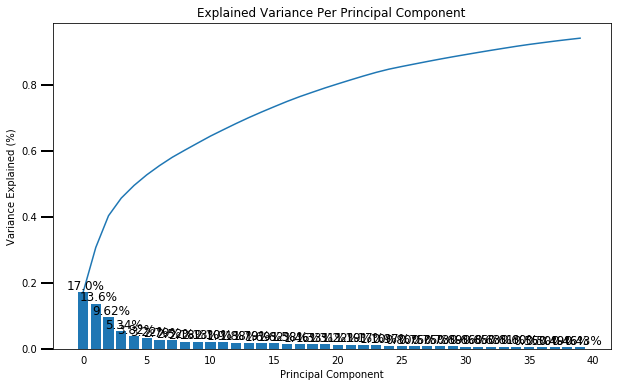

In [31]:
scree_plot(pca)

In [32]:
# Re-apply PCA to the data while selecting for number of components to retain.
# Note: from the above plot and "cumvals" result, when n_components = 25, cumvals ~ 0.85, so I will choose n_components = 25
n_components = 25
pca, azdias_pca = do_pca(n_components, azdias_imp_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

Answer: By looking at the plot and the cummulative variance, I found that when n_components = 25, the cummulative variance almost reaches 85%, so I decided to take n_components = 25 for the next step of the analysis.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [33]:
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_weights(pca, comp):
    if comp <= len(pca.components_):
        df = pd.DataFrame(pca.components_, columns = list(azdias_less_missing))
        weights = df.iloc[comp].sort_values(ascending = False) # sorting is considered inside the function
        return weights
    else:
        print('The given number is larger than the n_components, please check.')

In [34]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weights(pca, 0)

PLZ8_ANTG3               0.227551
PLZ8_ANTG4               0.220757
wealth                   0.208049
HH_EINKOMMEN_SCORE       0.204321
ORTSGR_KLS9              0.198145
EWDICHTE                 0.196338
FINANZ_HAUSBAUER         0.163234
PLZ8_ANTG2               0.154766
KBA05_ANTG4              0.153778
ARBEIT                   0.144377
FINANZ_SPARER            0.143351
ANZ_HAUSHALTE_AKTIV      0.136660
RELAT_AB                 0.136190
KBA05_ANTG3              0.135963
SEMIO_PFLICHT            0.112412
SEMIO_REL                0.109558
decade                   0.098092
SEMIO_RAT                0.092310
SEMIO_TRADV              0.085863
SEMIO_MAT                0.076758
SEMIO_FAM                0.075593
REGIOTYP                 0.073183
FINANZ_UNAUFFAELLIGER    0.070711
SEMIO_KULT               0.070151
FINANZ_ANLEGER           0.066845
KKK                      0.044006
SEMIO_SOZ                0.042122
PLZ8_HHZ                 0.041698
SEMIO_KAEM               0.040714
W_KEIT_KIND_HH

In [35]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weights(pca, 1)

ALTERSKATEGORIE_GROB     0.261331
FINANZ_VORSORGER         0.234005
SEMIO_ERL                0.231302
SEMIO_LUST               0.184300
RETOURTYP_BK_S           0.163703
W_KEIT_KIND_HH           0.119360
FINANZ_HAUSBAUER         0.116006
SEMIO_KRIT               0.114763
SEMIO_KAEM               0.111828
ANREDE_KZ                0.090281
PLZ8_ANTG3               0.089534
EWDICHTE                 0.088642
ORTSGR_KLS9              0.087220
PLZ8_ANTG4               0.085508
wealth                   0.072189
SEMIO_DOM                0.070423
FINANZ_MINIMALIST        0.068458
KBA05_ANTG4              0.066442
ARBEIT                   0.065619
RELAT_AB                 0.063020
PLZ8_ANTG2               0.061639
WOHNDAUER_2008           0.061562
ANZ_HAUSHALTE_AKTIV      0.061418
HH_EINKOMMEN_SCORE       0.054372
KBA05_ANTG3              0.040929
ANZ_HH_TITEL             0.030582
REGIOTYP                 0.020930
PLZ8_HHZ                 0.012135
ANZ_TITEL                0.007039
KKK           

In [36]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weights(pca, 2)

SEMIO_VERT               0.345242
SEMIO_SOZ                0.262297
SEMIO_FAM                0.250037
SEMIO_KULT               0.235452
FINANZ_MINIMALIST        0.155840
RETOURTYP_BK_S           0.108452
FINANZ_VORSORGER         0.101102
W_KEIT_KIND_HH           0.090905
ALTERSKATEGORIE_GROB     0.079077
SEMIO_REL                0.069634
SEMIO_LUST               0.064587
SEMIO_MAT                0.056023
GREEN_AVANTGARDE         0.046811
ORTSGR_KLS9              0.046064
EWDICHTE                 0.045422
PLZ8_ANTG4               0.045129
movement                 0.044877
PLZ8_ANTG3               0.044737
ARBEIT                   0.034751
WOHNDAUER_2008           0.033118
RELAT_AB                 0.031587
PLZ8_ANTG2               0.029813
wealth                   0.027669
KBA05_ANTG4              0.026868
ANZ_HAUSHALTE_AKTIV      0.025487
ANZ_HH_TITEL             0.013301
ANZ_TITEL                0.009601
KBA05_ANTG3              0.007974
PLZ8_HHZ                 0.003906
SOHO_KZ       

### Discussion 2.3: Interpret Principal Components

Answer:  
For the first principal component, it's very positively related to PLZ8_ANTG3, PLZ8_ANTG4, wealth, HH_EINKOMMEN_SCORE, ORTSGR_KLS9, and EWDICHTE, which are "Number of 6-10 family houses in the PLZ8 region", "Number of 10+ family houses in the PLZ8 region" "wealth", "net household income", "Size of community", "Density of households per square kilometer"; it's very negatively related to KBA05_GBZ, FINANZ_MINIMALIST, KBA05_ANTG1, PLZ8_ANTG1, and MOBI_REGIO, which are "Number of buildings in the microcell", "financial typology for low financial interest", "Number of 1-2 family houses in the microcell", "Movement patterns" and "Number of 1-2 family houses in the PLZ8 region".   
For the second principal component, it's very positively related to ALTERSKATEGORIE_GROB, FINANZ_VORSORGER, and SEMIO_ERL, which are "estimated age based on given name analysis", "financial typology for be prepared", "personality typology for event-oriented"; it's very negatively related to decade and SEMIO_REL, which are "decade of the person" and "Personality typology for religious".  
So generally speaking, the first principal component is more related to financial status and the second component is more related to personal status.  
If we zoom into each component, we can find some pattern between features, for example, from the first component, we may conclude that "Number of 6-10 family houses in the PLZ8 region" and "Number of 10+ family houses in the PLZ8 region" tend to increase together, and they share the opposite trend with "wealth" and "net household income" (note that although all these four are positively related to the first component, the label trend is opposite). This makes sense to me because the increasing number of large family houses usually indicates a lower income and wealth level.  
Another example is that from the second component, "decade" and "religious affinity" tend to have the same trend, which means senior people generally have higher religious affinity, and this is also consistent with daily life observations.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [42]:
# Over a number of different cluster counts...
def get_kmeans_score(data, center):
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(data)
    # compute the average within-cluster distances.
    score = np.abs(model.score(data))
    return score

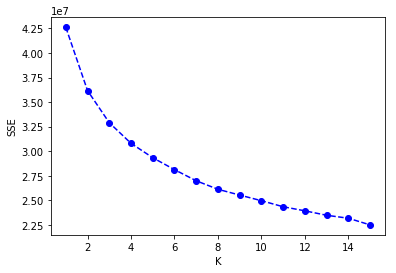

In [45]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
scores = []
centers = list(range(1,16))

for center in centers:
    scores.append(get_kmeans_score(azdias_pca, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');



In [37]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
n_center = 12
kmeans = KMeans(n_clusters = n_center)
model = kmeans.fit(azdias_pca)
azdias_pred = model.predict(azdias_pca)


### Discussion 3.1: Apply Clustering to General Population

Answer: From the SSE v.s. K plot, it seems that 12 is the elbow so I choose n_centers = 12.  
(To be honest, unlike the class example, it's really hard to tell the elbow location here... I generated the SSE v.s. K plot up to 10 and 15 but still could not see a clear elbow. I decided to move on since this step took too long time. If I have time to revisit this project I'll explore even larger values for n_centers. Also in my first draft I used n_centers = 13 but later when I plot count v.s. cluster I found that in both general and customers dataset the last cluster has very low count, so I decided to change n_centers from 13 to 12 and re-do the modeling.)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [38]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter = ';')

In [39]:
# clean the data
customers_clean = clean_data(customers)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_lau

In [40]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
# Cleaned the dataset of all NaN values
# New note to reviewer: I read the document about imputer and still think that the imputer part should be "fit_transform"
customers_imp = pd.DataFrame(imp.fit_transform(customers_clean), columns = list(customers_clean))
# Apply feature scaling to the general population demographics data.
# New note to reviewer: I agree that the scaling part should be "transform" instead of "fit_transform"
customers_imp_scaled = pd.DataFrame(scaler.transform(customers_imp), columns = list(customers_clean))
# Apply PCA:
# New note to reviewer: I also changed the PCA part to be "transform" instead of "fit_transform"
customers_pca = pca.transform(customers_imp_scaled)
# Prediction
customers_pred = model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'Customer Clusters')

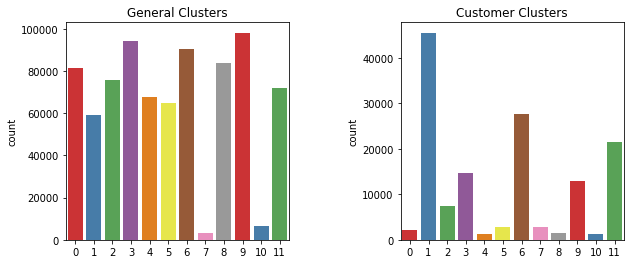

In [41]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,4))
figure.subplots_adjust(hspace = 0.5, wspace = 0.5)
# general
sns.countplot(azdias_pred, ax=axs[0], palette="Set1")
axs[0].set_title('General Clusters')
# customers
sns.countplot(customers_pred, ax=axs[1], palette="Set1")
axs[1].set_title('Customer Clusters')

In [42]:
# I tried to plot percentages instead of actual count in the above cell but I failed. So I will do the calculations manually and therefore I need to know the # of each dataset
print(len(azdias_pred))
print(len(customers_pred))

797961
141713


In [43]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# New notes: wow this looks very different now. It's clear that Cluster 1 is the only obvious overrepresented cluster in the customers dataset, compared to the general dataset
cluster_1 = scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[1]))
over_1 = pd.Series(data = cluster_1, index = customers_clean.columns)

In [44]:
print("cluster 1:\n", over_1)

cluster 1:
 ALTERSKATEGORIE_GROB        3.277546
ANREDE_KZ                   1.078513
FINANZ_MINIMALIST           4.818749
FINANZ_SPARER               1.634154
FINANZ_VORSORGER            4.160543
FINANZ_ANLEGER              1.507504
FINANZ_UNAUFFAELLIGER       2.176843
FINANZ_HAUSBAUER            1.888494
GREEN_AVANTGARDE            0.986845
HEALTH_TYP                  2.057653
RETOURTYP_BK_S              3.981858
SEMIO_SOZ                   5.268315
SEMIO_FAM                   4.820737
SEMIO_REL                   3.741039
SEMIO_MAT                   3.920201
SEMIO_VERT                  6.199455
SEMIO_LUST                  5.248674
SEMIO_ERL                   4.160630
SEMIO_KULT                  4.850245
SEMIO_RAT                   2.739690
SEMIO_KRIT                  3.259135
SEMIO_DOM                   3.402566
SEMIO_KAEM                  2.762218
SEMIO_PFLICHT               3.307999
SEMIO_TRADV                 3.167369
SOHO_KZ                    -0.000070
ANZ_PERSONEN              

In [45]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# New note: Similar to the "overrepresented" analysis, I found the results changed a lot after I did the minor revision. Now most of the clusters are underrepresented, especially in the cluster 0, 2, 4, 5, 8, and 9
# For simplicity I will do analysis on cluster 0, 4, and 8
cluster_0 = scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[0]))
cluster_4 = scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[4]))
cluster_8 = scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[8]))
under_0 = pd.Series(data = cluster_0, index = customers_clean.columns)
under_4 = pd.Series(data = cluster_4, index = customers_clean.columns)
under_8 = pd.Series(data = cluster_8, index = customers_clean.columns)

In [46]:
print("cluster 0:\n", under_0)
print("cluster 4:\n", under_4)
print("cluster 8:\n", under_8)

cluster 0:
 ALTERSKATEGORIE_GROB        1.701457
ANREDE_KZ                   1.986272
FINANZ_MINIMALIST           2.360390
FINANZ_SPARER               3.933158
FINANZ_VORSORGER            2.304558
FINANZ_ANLEGER              4.365356
FINANZ_UNAUFFAELLIGER       3.863035
FINANZ_HAUSBAUER            2.818467
GREEN_AVANTGARDE            0.200132
HEALTH_TYP                  2.224110
RETOURTYP_BK_S              2.581969
SEMIO_SOZ                   2.954451
SEMIO_FAM                   3.809314
SEMIO_REL                   5.357251
SEMIO_MAT                   5.168857
SEMIO_VERT                  2.526045
SEMIO_LUST                  3.142557
SEMIO_ERL                   4.321004
SEMIO_KULT                  4.077425
SEMIO_RAT                   6.255184
SEMIO_KRIT                  5.474737
SEMIO_DOM                   5.959162
SEMIO_KAEM                  5.638041
SEMIO_PFLICHT               6.188071
SEMIO_TRADV                 5.773077
SOHO_KZ                     0.000015
ANZ_PERSONEN              

In [50]:
# Compare between cluster 1 (overrepresented in the customers) and cluster 4 (underrepresented in the customers)
((over_1 - under_4)/over_1).sort_values(ascending=False)

ANZ_TITEL                 1.692723
SOHO_KZ                   1.605075
GREEN_AVANTGARDE          0.880037
movement                  0.870841
KBA05_ANTG1               0.862628
FINANZ_MINIMALIST         0.606568
MOBI_REGIO                0.580895
FINANZ_VORSORGER          0.486537
PLZ8_ANTG1                0.478738
KBA05_GBZ                 0.474443
life_stage                0.452685
SEMIO_ERL                 0.449456
ALTERSKATEGORIE_GROB      0.417546
SEMIO_LUST                0.403986
KONSUMNAEHE               0.389293
ANZ_PERSONEN              0.358039
PLZ8_GBZ                  0.311109
RETOURTYP_BK_S            0.287163
INNENSTADT                0.280764
KBA13_ANZAHL_PKW          0.253215
BALLRAUM                  0.233115
OST_WEST_KZ               0.224145
GEBAEUDETYP_RASTER        0.154849
WOHNDAUER_2008            0.149241
SEMIO_DOM                 0.146598
SEMIO_KRIT                0.126667
SEMIO_KAEM                0.103802
ANREDE_KZ                 0.103796
ONLINE_AFFINITAET   

### Discussion 3.3: Compare Customer Data to Demographics Data

Answer (revised after code revisions): Cluster 1 is overrepresented in the customers data than the general, while most other clusters are underrepresented in the customers data than the general, especially Clusters 0, 2, 4, 5, 8, and 9.  
If we compare Cluster 1 (over) and Cluster 4 (under), as shown in the above cell, "ANZ_TITLE" (Number of professional academic title holders in household) and "SOHO_KZ" (Small office / home office flag) are relatively popular with the mail-order company, and "PLZ8_ANTG4" (Number of 10+ family houses in the PLZ8 region), "ANZ_HAUSHALTE_AKTIV" (Number of households in the building), "KBA05_ANTG3" (Number of 6-10 family houses in the microcell) and "ANZ_HH_TITEL" (Number of professional academic title holders in building) and "KBA05_ANTG4" (Number of 10+ family houses in the microcell) are relatively unpopular with the company. So it seems to me that the company's customers are more likely to be higher professional and wealthy compare with the general population in Germany (the only obvious exception is "ANZ_HH_TITEL").

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.